Optimus Model

Peng et al. proposed Optimus scheduler for deep learning clusters which makes use of a predictive model to estimate the remaining time of a training job. Optimus assumes a parameter-server architecture for distributed training where synchronization between parameter server(s) and workers happen after every training step. The time taken to complete one training step on a worker includes the time for doing forward propagation (i.e., loss computation) and backward propagation (i.e., gradients computation) at the worker, the worker pushing gradients to parameter servers, parameter servers updating parameters, and the worker pulling updated parameters from parameter servers, plus extra communication overhead.

The predictive model proposed in Optimus is based on two sub-models, one to model the training loss as a function of number of steps and the other to model the training speed (training steps per unit time) as a function of resources (number of workers and parameter servers). The training loss model is given by Equation (1) in the paper. It has three parameters β0, β1, and β2 that needs to be estimated from the data.

#### Generating data

We train Resnet models with different number of layers (18, 20, 32, 44, 56) each with 3 different GPU types (K80, P100, V100). 

For these runs we use CIFAR10, a batch size of 128, and run each job for 350 epochs.

See details of training on train.py

#### Loading data

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

directory = '/content/drive/MyDrive/DLHW4/results/'
models = os.listdir(directory)
models = [
 'resnet20-p100',
 'resnet32-k80',
 'resnet56-p100',
 'resnet32-p100',
 'resnet32-v100',
 'resnet44-p100',
 'resnet56-v100',
 'resnet56-k80',
 'resnet44-k80',
 'resnet18-p100',
 'resnet44-v100',
 'resnet18-k80',
 'resnet20-k80',
 'resnet20-v100',
 'resnet18-v100',
'resnet50-p100',
 'resnet50-k80',
 'resnet50-v100']

In [ ]:
li = []
for model in models:
  #read in data for the model
  txt = model.split("-")
  resnet = int(txt[0][-2:])
  gpu = txt[1]
  path = os.path.join(directory, model, 'results.csv')
  df = pd.read_csv(path)
  df['resnet_type'] = resnet
  df['gpu'] = gpu
  li.append(df)

results = pd.concat(li, axis=0, ignore_index=True)

# Normalize loss values to be between 0 and 1
results['validation loss'] = results['validation loss']/np.max(results['validation loss'])
results

,epoch,steps,training step,training data,training loss,training prec1,training prec5,training error1,training error5,validation step,validation data,validation loss,validation prec1,validation prec5,validation error1,validation error5,resnet_type,gpu
0,1,390,0.043203,0.005909,1.722429,34.433093,86.360176,65.566907,13.639824,0.027253,0.016188,0.911111,37.89,85.32,62.11,14.68,20,p100
1,2,780,0.041745,0.004852,1.234715,55.320513,94.793670,44.679487,5.206330,0.026258,0.015339,0.710129,53.69,93.98,46.31,6.02,20,p100
2,3,1170,0.042549,0.004841,0.977884,64.679487,96.981170,35.320513,3.018830,0.027678,0.016464,0.577891,62.37,96.90,37.63,3.10,20,p100
3,4,1560,0.041559,0.004927,0.853930,69.635417,97.734375,30.364583,2.265625,0.027271,0.015469,0.569924,62.12,96.26,37.88,3.74,20,p100
4,5,1950,0.042220,0.005119,0.753844,73.371394,98.285256,26.628606,1.714744,0.027389,0.016089,0.400937,72.27,98.37,27.73,1.63,20,p100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5455,66,25740,0.059583,0.005761,0.155884,94.467147,99.941907,5.532853,0.058093,0.034827,0.009799,0.218641,87.42,99.42,12.58,0.58,50,v100
5456,67,26130,0.060048,0.005244,0.155561,94.395032,99.951923,5.604968,0.048077,0.035926,0.007839,0.227154,87.66,99.60,12.34,0.40,50,v100
5457,68,26520,0.058589,0.005658,0.162138,94.292869,99.929888,5.707131,0.070112,0.034269,0.008002,0.244448,85.78,99.47,14.22,0.53,50,v100
5458,69,26910,0.059595,0.005357,0.147321,94.735577,99.955929,5.264423,0.044071,0.035110,0.008186,0.192098,89.06,99.67,10.94,0.33,50,v100


#### Calibrating a loss model based on gpu and steps

This gives us the parameters (β0, β1, β2)

In [ ]:
def func(k, beta0, beta1, beta2):
    return 1./(beta0 * k + beta1) + beta2 

#check for resnet 18 and k80 gpu
x = results[(results.resnet_type == resnets[0]) & (results.gpu == gpu[0])]['steps']
y = results[(results.resnet_type == resnets[0]) & (results.gpu == gpu[0])]['validation loss']

popt, pocv = curve_fit(func, x, y)
print(popt[0],popt[1],popt[2])

from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, x, y, p0=[0.001, 0.1, 1]) 
print("beta0, beta1, beta2: ", popt)

fitted = func(x, *popt)
plt.plot(x,y, label = 'train loss')
plt.legend('training loss')
plt.plot(x, fitted, label = 'fit')
plt.legend()
plt.title('Resnet 20 on K80 GPU')
plt.show()


-88660.36460267636 -26058712.92425362 0.2122091224214841
beta0, beta1, beta2:  [0.00115982 1.03799221 0.18168209]


In [ ]:
X = pd.get_dummies(data=fit_df[['resnet_type','gpu']])
print(X)

    resnet_type  gpu_k80  gpu_p100  gpu_v100
0            18        1         0         0
1            20        1         0         0
2            32        1         0         0
3            44        1         0         0
4            56        1         0         0
5            18        0         1         0
6            20        0         1         0
7            32        0         1         0
8            44        0         1         0
9            56        0         1         0
10           18        0         0         1
11           20        0         0         1
12           32        0         0         1
13           44        0         0         1
14           56        0         0         1


#### Second Model
We use a regression model on the data from 15 models to predict the value of the parameters as a function of number of layers in Resnet and GPU type

In [ ]:
from sklearn.linear_model import LinearRegression

betas = ['beta0', 'beta1', 'beta2']
weights = {}
intercept = {}

#run regression for each beta & store the weights
for beta in betas:
  y_b = fit_df[beta]
  model = LinearRegression()
  model.fit(X,y_b)
  b_weights = model.coef_
  b_int = model.intercept_

  weights[beta] = b_weights
  intercept[beta] = b_int
print(weights)

#get features
def get_features(resnet_type, gpu):
  feat = [resnet_type,0,0,0]
  if(gpu =='k80'):
    feat[1] = 1
  elif(gpu =='p100'):
    feat[2] = 1
  else:
    feat[3] =1
  return feat

#make prediction
def pred_betas(resnet_type, gpu):
  x = get_features(resnet_type, gpu)
  beta_pred = []
  for beta in betas:
      beta_pred.append(np.dot(weights[beta],x) + intercept[beta])
  return beta_pred

In [ ]:
#resnet-50: k80, v100, and p100
print('resnet 50')
#k80
beta_k80 =  pred_betas(50, 'k80')
print('k80 -----' , beta_k80)

#p100
beta_p100= pred_betas(50, 'p100')
print('p100 -----' , beta_p100)

#v100
beta_v100= pred_betas(50, 'v100')
print('v100 -----' , beta_v100)


resnet 50
k80 ----- [0.0017510030965049014, 0.8609535331356217, 0.17174845281728882]
p100 ----- [0.0016824166483081211, 0.9852815305344742, 0.17210937317353522]
v100 ----- [0.0016413461428303477, 1.0976642414169053, 0.17031963621319834]


#### Predict the training loss curve for Resnet-50

We see that number of epochs required to reach convergence is independent of hardware.

percentage error  0.23969102699545144


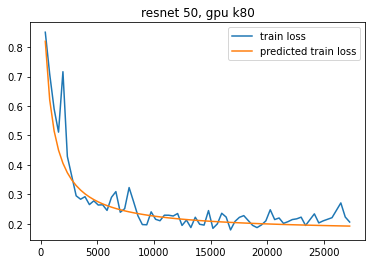

max validation accuracy  88.75
max epoch  60
percentage error  0.19566639737959982


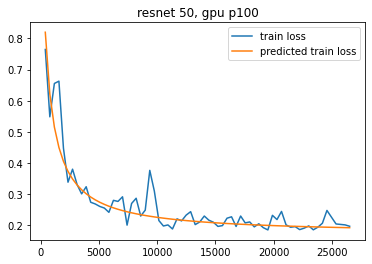

max validation accuracy  88.88
max epoch  57
percentage error  0.11575103421405894


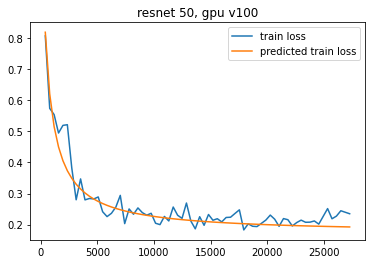

max validation accuracy  88.74
max epoch  49


In [ ]:
#get predicted curve vs actual curve for resnet 50
#doing 89% accuracy, as I did not have time to run to 92%

from sklearn.metrics import mean_squared_error
gpu = ['k80', 'p100', 'v100']

res50_subset = results[(results.resnet_type == 50) & (results['validation prec1'] <= 89.00)]

for g in gpu:
  #get actual fit curves
  x = res50_subset[res50_subset.gpu == g]['steps']
  y = res50_subset[res50_subset.gpu == g]['validation loss']
  plt.plot(x,y, label = 'train loss')
  fitted = func(x, beta_k80[0], beta_k80[1], beta_k80[2])

  err = mean_squared_error(y, fitted)*100
  print('percentage error ' ,err)

  plt.plot(x, fitted, label = 'predicted train loss')
  plt.title('resnet 50, gpu {}'.format(g))
  plt.legend()
  plt.show()

  max_acc = np.max(res50_subset[res50_subset.gpu == g]['validation prec1'])
  print('max validation accuracy ', max_acc)
  max_epoch = res50_subset[res50_subset['validation prec1'] == max_acc]['epoch']
  print('max epoch ', max_epoch.values[0])


In [ ]:
  max_acc = np.max(res50_subset[res50_subset.gpu == 'k80']['validation prec1'])
  print('max validation accuracy ', max_acc)
  max_epoch = res50_subset[res50_subset['validation prec1'] == max_acc]
  max_epoch
  print('max epoch ', max_epoch.values[0])

max validation accuracy  88.75


,epoch,steps,training step,training data,training loss,training prec1,training prec5,training error1,training error5,validation step,validation data,validation loss,validation prec1,validation prec5,validation error1,validation error5,resnet_type,gpu
5379,60,23400,0.171591,0.001459,0.169998,93.882212,99.917869,6.117788,0.082131,0.062918,0.008687,0.194487,88.75,99.48,11.25,0.52,50,k80


max epoch to reach 88% accuracy seem to be around 57-60 for p100 and k80.

Both P100 and K80 were run on colab but v100 was on GCP.
The max epoch on V100 is likely different because of this. 

## Time to accuracy for Resnet-50

$f(p,w)=(θ_{0}·\frac{M}{w}+θ_{1}+θ_{2}·\frac{w}{p}+θ_{3}·w+θ_{4}·p)^{-1}$

Coefficients-

$θ_{0} = 1.02$ <br/>
$θ_{1} = 2.73$ <br/>
$θ_{2} = 4.92$ <br/>
$θ_{3} = 0.00$ <br/>
$θ_{4} = 0.02$ <br/>


M = 64<br/>

2 parameter server options <br/>
p = [2,4]

Vary worker w from 0 to 20<br/>
w = range(0,20)




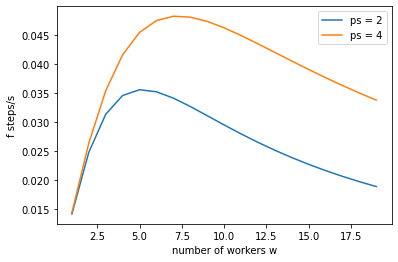

In [ ]:
import math

def resource_model(M, p,w):
  #training speed function for synchronous training
  theta0 = 1.02
  theta1 = 2.73
  theta2 = 4.92
  theta3= 0.00
  theta4=0.02

  fn = theta0*(M/w)+theta1+theta2*(w/p) + theta3*w + theta4*p
  return 1/fn

fn_ps2 = [resource_model(64, 2,w) for w in range(1,20)]

plt.plot(range(1,20), fn_ps2, label ='ps = 2')

fn_ps4 = [resource_model(64, 4,w) for w in range(1,20)]

plt.plot(range(1,20), fn_ps4, label = 'ps = 4')
plt.legend()
plt.ylabel('f steps/s')
plt.xlabel('number of workers w')
plt.show()





f gives us steps/second

If we say we need 25,000 steps to converge, the the time needed to converge is

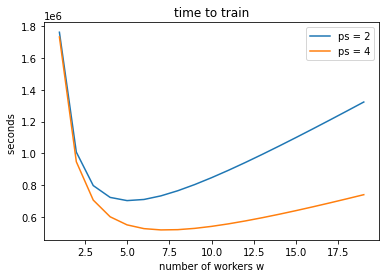

In [ ]:
def resource_model(M, p,w):
  STEPS = 25000
  #training speed function for synchronous training
  theta0 = 1.02
  theta1 = 2.73
  theta2 = 4.92
  theta3= 0.00
  theta4=0.02
  
  #fn gives seconds/step
  fn = theta0*(M/w)+theta1+theta2*(w/p) + theta3*w + theta4*p
  #multiply by number of steps to get total seconds 
  return fn*STEPS

fn_ps2 = [resource_model(64, 2,w) for w in range(1,20)]

plt.plot(range(1,20), fn_ps2, label ='ps = 2')

fn_ps4 = [resource_model(64, 4,w) for w in range(1,20)]

plt.plot(range(1,20), fn_ps4, label = 'ps = 4')
plt.legend()
plt.ylabel('seconds ')
plt.xlabel('number of workers w')
plt.title('time to train')
plt.show()
